In [362]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

N - количество осей (размерность) <br>
M - количество точек <br>
minValue - минимальное значение для иксов <br>
maxValue - максимальное значение для иксов

In [363]:
N = 1
M = 10
minValue = 0
maxValue = 10
STEPS = 1e3
EPS = 1e-6
K = 1e-2


In [364]:
def yRegression(B, X):
    return np.sum(X * B)

B_reg = []
for i in range(N + 1):
    bi = random.randint(minValue, maxValue)
    B_reg.append(bi)
B_reg = np.array(B_reg, dtype='float64')
print(B_reg)
XM = []
YM = []
YR = []
for i in range(M):
    X = [1]
    for j in range(N):
        xj = random.randint(minValue, maxValue)
        X.append(xj)
    X = np.array(X)
    rand_delta = random.randint(-maxValue, maxValue)
    Y_r = yRegression(B_reg, X)
    Y_act = Y_r + random.randint(0, 10) * rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
    YR.append(Y_r)
XM = np.array(XM)
YM = np.array(YM)
YR = np.array(YR)
print(XM)
print(YM)
print(YR)

[10.  7.]
[[ 1  9]
 [ 1  2]
 [ 1  4]
 [ 1  5]
 [ 1 10]
 [ 1 10]
 [ 1  2]
 [ 1  8]
 [ 1  8]
 [ 1  4]]
[113.  88. -11.  95. 160.  80.  21. 106.  51.  53.]
[73. 24. 38. 45. 80. 80. 24. 66. 66. 38.]


0 21011.199999999997
21011.199999999997 13932.41088
13932.41088 16075.907842048004
16075.907842048004 13726.384046918862
13726.384046918862 14829.619196935722
14829.619196935722 13959.520252621505
13959.520252621505 14449.197524557523
14449.197524557523 14108.284663445158
14108.284663445158 14315.196945419844
14315.196945419844 14178.156094589436
14178.156094589436 14263.971119866734
14263.971119866734 14208.274901242758
14208.274901242758 14243.603204000014
14243.603204000014 14220.863133509774
14220.863133509774 14235.363548348729
14235.363548348729 14226.06147973124
14226.06147973124 14232.00587308825
14232.00587308825 14228.197803383136
14228.197803383136 14230.633469695375
14230.633469695375 14229.074029552252
14229.074029552252 14230.071819870991
14230.071819870991 14229.43313110467
14229.43313110467 14229.841849741742
14229.841849741742 14229.580252539805
14229.580252539805 14229.74766767353
14229.74766767353 14229.640519089813
14229.640519089813 14229.709092996316
14229.7090929

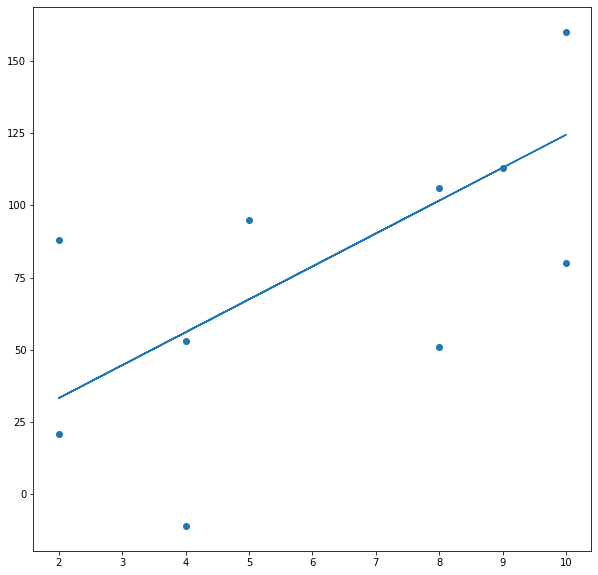

In [365]:
def squaredError(Y_act, Y_reg):
    error = 0
    for i in range(M):
        error += (Y_act[i] - Y_reg[i]) ** 2
    return error

def stoppingCriteria(previous, current):
    return abs(previous - current) < EPS

def gradient(nums, XM, YR, YM):
    grad = []
    for i in range(N + 1):
        xi = 0
        for j in range(len(nums)):
            xi += XM[nums[j]][i] * (YR[nums[j]] - YM[nums[j]])
        xi *= 2
        grad.append(xi)
    # print(grad)
    return np.array(grad)

def gradientDescent(batch, XM, YM, YR, B_reg):
    previous = 0
    while True:
        nums = set()
        while len(nums) != batch:
            x = random.randint(0, N - 1)
            if x not in nums:
                nums.add(x)

        nums = np.array(list(nums))
        # print(nums)
        grad = gradient(nums, XM, YR, YM)
        # print(grad)
        B_reg -= K * grad
        # print(B_reg)
        for i in range(M):
            YR[i] = yRegression(B_reg, XM[i])
        print(previous, squaredError(YM, YR))
        if stoppingCriteria(previous, squaredError(YM, YR)):
            break
        previous = squaredError(YM, YR)
    return B_reg

B_final = gradientDescent(1, XM, YM, YR, B_reg)
YF = []
for i in range(M):
    y_fi = yRegression(B_final, XM[i])
    YF.append(y_fi)
print("actual=", YM)
print("starting=", YR)
print("regression=", YF)

def drawGraph(XM, YM, YF):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF)
    plt.show()

drawGraph(XM, YM, YF)